In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime as dt
import yfinance as yf


In [33]:
def load_data(file_path):
    """Load historical price data from an Excel file."""
    return pd.read_excel(file_path, index_col=0, parse_dates=True)

In [34]:
bond1 = 'Price History_20+_US_TBills.xlsx'
bond2 = 'Price History_7-10_US_TBills.xlsx'
equity = 'Price History_IVV_US_Equity.xlsx'
gold = 'Price History_IAU_Gold_Trust.xlsx'

In [35]:
bond1_df = load_data(bond1)
bond2_df = load_data(bond2)
equity_df = load_data(equity)
gold_df = load_data(gold)

In [36]:
print("Bond 20+ Years:", bond1_df.head())
print("Bond 7-10 Years:", bond2_df.head())
print("Equity (IVV):", equity_df.head())
print("Gold (IAU):", gold_df.head())

Bond 20+ Years:                Close   Net      %Chg   Open     Low    High    Volume  \
Exchange Date                                                           
2024-12-13     90.15 -0.93 -0.010211  90.80  90.080  90.850  39485960   
2024-12-12     91.08 -1.12 -0.012148  91.64  91.000  91.746  45368386   
2024-12-11     92.20 -0.88 -0.009454  93.07  92.105  93.290  38748397   
2024-12-10     93.08 -0.44 -0.004705  93.02  92.905  93.300  28706474   
2024-12-09     93.52 -0.87 -0.009217  93.99  93.465  94.040  30509582   

               Turnover - USD  
Exchange Date                  
2024-12-13       3.565789e+09  
2024-12-12       4.141473e+09  
2024-12-11       3.582040e+09  
2024-12-10       2.672502e+09  
2024-12-09       2.856887e+09  
Bond 7-10 Years:                Close   Net      %Chg    Open      Low    High   Volume  \
Exchange Date                                                            
2024-12-13     93.69 -0.44 -0.004674  93.980  93.6438  94.005  5230061   
2024-12-1

In [37]:
# Data Preprocessing
def preprocess_data(df):
    """Clean and preprocess the dataset."""
    df = df.dropna().copy()  # Remove missing values and avoid SettingWithCopyWarning
    df.loc[:, 'Returns'] = np.log(df['Close'] / df['Close'].shift(1))  # Compute log returns
    return df

In [38]:
# Apply preprocessing
dataframes = {'bond1': bond1_df, 'bond2': bond2_df, 'equity': equity_df, 'gold': gold_df}
for key in dataframes:
    dataframes[key] = preprocess_data(dataframes[key])


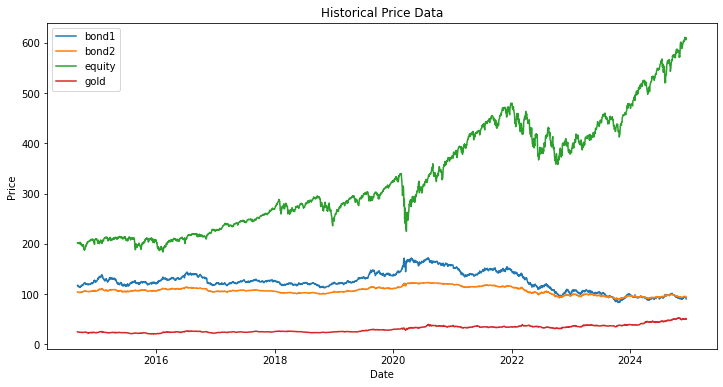

In [39]:
# Plot historical prices
plt.figure(figsize=(12, 6))
for key, df in dataframes.items():
    plt.plot(df.index, df['Close'], label=key)
plt.legend()
plt.title("Historical Price Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [40]:
# Compute volatility
def compute_volatility(df, window=30):
    """Compute rolling volatility."""
    return df['Returns'].rolling(window).std() * np.sqrt(252)  # Annualized volatility

# Add volatility to dataframes
for key in dataframes:
    dataframes[key].loc[:, 'Volatility'] = compute_volatility(dataframes[key])

In [47]:
# Add volatility to dataframes
for key in dataframes:
    dataframes[key].loc[:, 'Volatility'] = compute_volatility(dataframes[key])

# Fetch market data for option parameters
symbol = "AAPL"  # Example stock
data = yf.Ticker(symbol)
historical_data = data.history(period="1y")
S = historical_data["Close"].iloc[-1]  # Last closing price

option_expiry = dt.datetime(2025, 12, 20)  # Example expiration date
T = (option_expiry - dt.datetime.today()).days / 365  # Time to maturity in years

risk_free_rate = yf.Ticker("^IRX").history(period="1d")["Close"].iloc[-1] / 100  # 13-week T-bill rate as proxy for risk-free rate

sigma = historical_data["Close"].pct_change().std() * np.sqrt(252)  # Historical volatility estimate

K = round(S * 1.05, 2)  # Strike price at 5% above current price


In [48]:
print(T)

0.7671232876712328


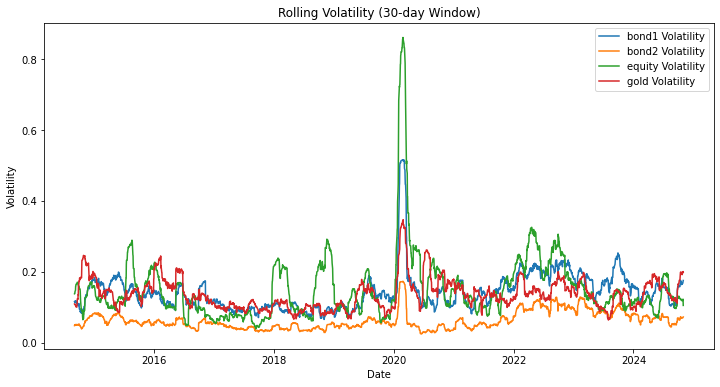

In [42]:
# Display volatility trends
plt.figure(figsize=(12, 6))
for key, df in dataframes.items():
    plt.plot(df.index, df['Volatility'], label=f"{key} Volatility")
plt.legend()
plt.title("Rolling Volatility (30-day Window)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

In [49]:
# Black-Scholes Option Pricing Model
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """Compute the Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

call_price = black_scholes(S, K, T, risk_free_rate, sigma, option_type="call")
put_price = black_scholes(S, K, T, risk_free_rate, sigma, option_type="put")

print(f"Black-Scholes Call Price: {call_price}")
print(f"Black-Scholes Put Price: {put_price}")
print("\nInterpretation:")
print(f"- The call price ({call_price}) represents the theoretical value of the right to buy {symbol} at strike price {K}.")
print(f"- The put price ({put_price}) represents the theoretical value of the right to sell {symbol} at strike price {K}.")
print("- These values assume no arbitrage opportunities and rely on inputs such as volatility and risk-free rate.")


Black-Scholes Call Price: 16.687048329000547
Black-Scholes Put Price: 20.228166699120933

Interpretation:
- The call price (16.687048329000547) represents the theoretical value of the right to buy AAPL at strike price 221.58.
- The put price (20.228166699120933) represents the theoretical value of the right to sell AAPL at strike price 221.58.
- These values assume no arbitrage opportunities and rely on inputs such as volatility and risk-free rate.


In [44]:
# Save processed data
for key, df in dataframes.items():
    df.to_csv(f"processed_{key}.csv")

print("Data preprocessing complete. Saved processed data to CSV files.")

Data preprocessing complete. Saved processed data to CSV files.
